# Import 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Explore

In [2]:
df_meta = pd.read_csv('/projects/cpjump1/jump/metadata/complete_metadata.csv', low_memory=False)

In [3]:
df_meta_mol = df_meta[df_meta['Metadata_PlateType'] == 'COMPOUND']
df_mol = df_meta_mol[['Metadata_JCP2022', 'Metadata_InChI', 'Metadata_InChIKey']].drop_duplicates(inplace=False).reset_index(drop=True)

In [4]:
df_mol

,Metadata_JCP2022,Metadata_InChI,Metadata_InChIKey
0,JCP2022_033924,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N
1,JCP2022_085227,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,SRVFFFJZQVENJC-UHFFFAOYSA-N
2,JCP2022_036592,InChI=1S/C17H12ClF3N4O2/c1-24(15-13(18)6-9(7-2...,IPPYTNWGGOIMDZ-UHFFFAOYSA-N
3,JCP2022_071885,InChI=1S/C10H7ClN4/c11-9-3-1-2-8(4-9)6-15-7-13...,PYZMXVUWLLQNEP-UHFFFAOYSA-N
4,JCP2022_088861,InChI=1S/C18H12FN3O2/c19-14-3-1-2-4-15(14)21-1...,UFLMHYAKMYTSFT-UHFFFAOYSA-N
...,...,...,...
115728,JCP2022_077772,InChI=1S/C19H23FN4O2/c1-14-3-5-15(6-4-14)13-26...,RECBFDWSXWAXHY-UHFFFAOYSA-N
115729,JCP2022_084183,"InChI=1S/C21H21N5O/c1-21(2,3)16-6-4-15(5-7-16)...",SMJAMOAYGIVKRI-UHFFFAOYSA-N
115730,JCP2022_057881,InChI=1S/C21H22ClFN4O2/c22-15-3-6-19-18(13-15)...,NBHPRWLFLUBAIE-UHFFFAOYSA-N
115731,JCP2022_060166,InChI=1S/C19H21N3O3/c1-13-6-8-22(9-7-13)17-4-2...,NNPCFFIJVKYGHR-UHFFFAOYSA-N


In [5]:
df_chembl = pd.read_csv('/projects/synsight/repos/phenoseeker/data/ChEMBL/chembl_activity_data.csv', low_memory=False)
df_assays = pd.read_csv('/projects/synsight/repos/phenoseeker/data/ChEMBL/assay.csv')

/tmp/ipykernel_1280814/1144412193.py:2: DtypeWarning: Columns (4,5,8,17,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_assays = pd.read_csv('/projects/synsight/repos/phenoseeker/data/ChEMBL/assay.csv')


In [6]:
df_assays

,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,...,curated_by,src_id,src_assay_id,chembl_id,cell_id,bao_format,tissue_id,variant_id,aidx,assay_group
0,1,11087,The compound was tested for the in vitro inhib...,B,NaN,NaN,NaN,NaN,NaN,NaN,...,Autocuration,1,NaN,CHEMBL615117,NaN,BAO_0000019,NaN,NaN,CLD0,NaN
1,2,684,Compound was evaluated for its ability to mobi...,F,NaN,NaN,NaN,NaN,NaN,NaN,...,Autocuration,1,NaN,CHEMBL615118,NaN,BAO_0000219,NaN,NaN,CLD0,NaN
2,3,15453,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,...,Autocuration,1,NaN,CHEMBL615119,NaN,BAO_0000019,NaN,NaN,CLD0,NaN
3,4,17841,Binding affinity against A2 adenosine receptor...,B,NaN,NaN,Bos taurus,9913.0,NaN,Striatum,...,Autocuration,1,NaN,CHEMBL615120,NaN,BAO_0000249,2435.0,NaN,CLD0,NaN
4,5,17430,In vitro cell cytotoxicity against 143-B cell ...,F,NaN,NaN,Homo sapiens,9606.0,NaN,NaN,...,Intermediate,1,NaN,CHEMBL615121,163.0,BAO_0000219,NaN,NaN,CLD0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740541,2421846,128726,Selectivity interaction (Inhibition of CYP enz...,B,In vitro,Selectivity assay,Homo sapiens,9606.0,NaN,Liver,...,Autocuration,65,NaN,CHEMBL5482965,NaN,BAO_0000251,2107.0,NaN,S_41804_592_330202,NaN
1740542,2421847,128726,Selectivity interaction (Inhibition of CYP enz...,B,In vitro,Selectivity assay,Homo sapiens,9606.0,NaN,Liver,...,Autocuration,65,NaN,CHEMBL5482966,NaN,BAO_0000251,2107.0,NaN,S_41804_601_330203,NaN
1740543,2421848,128726,Selectivity interaction (Time-dependent inacti...,B,In vitro,Selectivity assay,Homo sapiens,9606.0,NaN,Liver,...,Autocuration,65,NaN,CHEMBL5482967,NaN,BAO_0000251,2107.0,NaN,S_41804_601_330204,NaN
1740544,2421849,128726,Selectivity interaction (KinomeScan (DiscoverX...,B,In vitro,Selectivity assay,Homo sapiens,9606.0,NaN,NaN,...,Autocuration,65,NaN,CHEMBL5482968,NaN,BAO_0000357,NaN,NaN,S_42105_68_342694,NaN


In [7]:
len(df_chembl.columns)

79

In [8]:
assay_index = df_chembl.columns

In [9]:
allowed_assays = [int(x) for x in assay_index if x.isdigit()]

# Supposons que votre DataFrame s'appelle df et qu'elle possède une colonne 'assay_id'
filtered_df = df_assays[df_assays['assay_id'].isin(allowed_assays)]



In [10]:
df_assays['assay_category'].value_counts()

assay_category
Selectivity assay                       19517
confirmatory                             2775
Affinity phenotypic cellular assay       1810
Affinity biochemical assay                490
Affinity on-target cellular assay         282
other                                     182
Thermal shift assay                       171
PDSP assay                                 86
GPCR beta-arrestin recruitment assay       71
screening                                  39
NanoBRET assay                             29
Alphascreen assay                          26
ITC assay                                  25
HTRF assay                                  4
summary                                     3
Cell health data                            3
Incucyte cell viability                     3
Name: count, dtype: int64

In [11]:
df_chembl

,molregno,688128,688133,688141,688155,688157,688161,688170,688238,688267,...,1301485,1301545,1301593,1301620,1301624,1301866,1301890,1495346,1495379,standard_inchi_key
0,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IENZQIKPVFGBNW-UHFFFAOYSA-N
1,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,GSDSWSVVBLHKDQ-UHFFFAOYSA-N
2,147,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MHWLWQUZZRMNGJ-UHFFFAOYSA-N
3,173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CGIGDMFJXJATDK-UHFFFAOYSA-N
4,205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOCJXYPHIIZEHN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21211,1826829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CKUFOBCNTCLXJP-UHFFFAOYSA-N
21212,1941955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,PNUZDKCDAWUEGK-UHFFFAOYSA-N
21213,1941988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,KWYVBDFTFOKSNG-UHFFFAOYSA-N
21214,1942900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,MZTYAVVWCUVWPU-UHFFFAOYSA-N


In [12]:
cols = df_chembl.columns.difference(['molregno', 'standard_inchi_key'])

# Compter le nombre de 1 par colonne
count_1 = (df_chembl[cols] == 1).sum()

# Compter le nombre de -1 par colonne
count_neg1 = (df_chembl[cols] == -1).sum()

# Créer un DataFrame récapitulatif
summary_df = pd.DataFrame({
    'count_1': count_1,
    'count_-1': count_neg1
})

In [13]:
summary_df


,count_1,count_-1
1301460,102,55
1301485,31,76
1301545,24,2293
1301593,71,51
1301620,30,1106
...,...,...
845225,34,346
845245,19,728
845256,9,104
954333,35,180


In [14]:
summary_df['hit rate'] = summary_df['count_1'] / (summary_df['count_1'] + summary_df['count_-1'])   *100

Assay 688128 (chembl_id: CHEMBL1614161) ignored (ratio 511/187 >= 0.40 or no inactives)
Assay 688141 (chembl_id: CHEMBL1614174) ignored (ratio 610/91 >= 0.40 or no inactives)
Assay 688161 (chembl_id: CHEMBL1614240) ignored (ratio 115/59 >= 0.40 or no inactives)
Assay 688238 (chembl_id: CHEMBL1614458) ignored (ratio 1055/286 >= 0.40 or no inactives)
Assay 688341 (chembl_id: CHEMBL1614281) ignored (ratio 175/94 >= 0.40 or no inactives)
Assay 688360 (chembl_id: CHEMBL1614342) ignored (ratio 759/131 >= 0.40 or no inactives)
Assay 688386 (chembl_id: CHEMBL1614414) ignored (ratio 86/112 >= 0.40 or no inactives)
Assay 688489 (chembl_id: CHEMBL1613910) ignored (ratio 645/61 >= 0.40 or no inactives)
Assay 688546 (chembl_id: CHEMBL1613992) ignored (ratio 222/155 >= 0.40 or no inactives)
Assay 688549 (chembl_id: CHEMBL1613995) ignored (ratio 172/89 >= 0.40 or no inactives)
Assay 688612 (chembl_id: CHEMBL1614079) ignored (ratio 271/118 >= 0.40 or no inactives)
Assay 688687 (chembl_id: CHEMBL161422

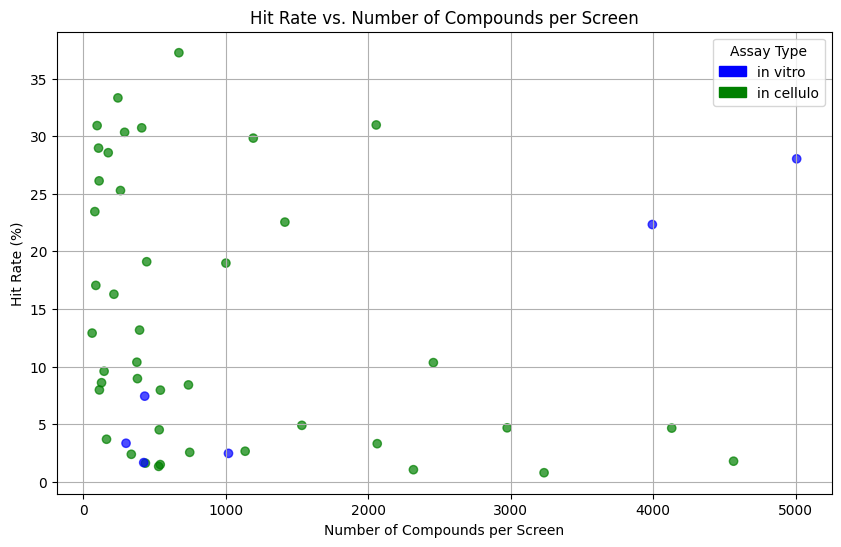

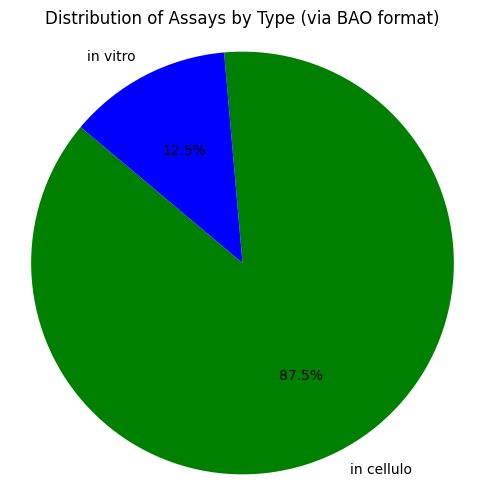

In [17]:
df_merged = df_chembl.merge(
    df_mol,
    how="left",
    left_on="standard_inchi_key",
    right_on="Metadata_InChIKey"
)

# --- Determine the assay columns to process (excluding 'molregno' and 'standard_inchi_key')
colonnes_assays = [col for col in df_chembl.columns if col not in ["molregno", "standard_inchi_key"]]

# List to hold summary statistics for each assay
results_list = []

# --- Define a mapping function that uses bao_format to assign an assay type.
def map_assay_bao(bao_format):
    """
    Map the bao_format value to one of three groups based on BAO codes.
    
    Mapping:
      - BAO_0000357 and BAO_0000218: in vitro
      - BAO_0000019 and BAO_0000219: in cellulo
      - Others or missing: other
    """
    if pd.isna(bao_format):
        return "other"
    
    mapping = {
        "BAO_0000357": "in vitro",
        "BAO_0000218": "in vitro",
        "BAO_0000019": "in cellulo",
        "BAO_0000219": "in cellulo"
    }
    return mapping.get(bao_format, "other")

# --- Loop through each assay column
for assay_col in colonnes_assays:
    try:
        assay_int = int(assay_col)
    except ValueError:
        continue

    mask_assay = (df_assays["assay_id"] == assay_int)
    if mask_assay.sum() == 0:
        continue

    chembl_id_value = df_assays.loc[mask_assay, "chembl_id"].values[0]
    bao_value = df_assays.loc[mask_assay, "bao_format"].values[0]
    assay_type = map_assay_bao(bao_value)

    # Filter records with nonzero assay values
    df_filtered = df_merged[df_merged[assay_col] != 0].copy()
    if df_filtered.empty:
        continue

    # Count active (value 1) and inactive (value -1) compounds
    active_count = (df_filtered[assay_col] == 1).sum()
    inactive_count = (df_filtered[assay_col] == -1).sum()
    total_count = active_count + inactive_count

    # Apply criteria: ignore assay if no inactives or if hit rate (active/total) is >= 0.40
    if inactive_count == 0 or (active_count / total_count) >= 0.40:
        print(f"Assay {assay_col} (chembl_id: {chembl_id_value}) ignored "
              f"(ratio {active_count}/{inactive_count} >= 0.40 or no inactives)")
        continue

    hit_rate = active_count / total_count

    results_list.append({
         "assay": assay_col,
         "chembl_id": chembl_id_value,
         "bao_format": bao_value,
         "assay_type": assay_type,
         "active_count": active_count,
         "inactive_count": inactive_count,
         "total_count": total_count,
         "hit_rate": hit_rate,
    })

# Create DataFrame from results
df_results = pd.DataFrame(results_list)

# --- Define color mapping for assay types
group_colors = {
    "in vitro": "blue",
    "in cellulo": "green",
}
df_results["color"] = df_results["assay_type"].map(group_colors)

# --- Scatter Plot: Hit rate vs. Number of compounds, colored by assay type
plt.figure(figsize=(10,6))
plt.scatter(df_results["total_count"], df_results["hit_rate"]*100, 
            c=df_results["color"], alpha=0.7)
plt.xlabel("Number of Compounds per Screen")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs. Number of Compounds per Screen")
plt.grid(True)

# Create legend handles
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
plt.legend(handles=legend_handles, title="Assay Type")
plt.show()

# --- Pie Chart: Distribution of assays by assay type
group_counts = df_results["assay_type"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(group_counts.values, labels=group_counts.index, 
        colors=[group_colors.get(g, "gray") for g in group_counts.index],
        autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Assays by Type (via BAO format)")
plt.axis('equal')
plt.show()


        screen  active_count  inactive_count  total_count  hit_rate
0   in-cellulo           104             252          356  0.292135
1   in-cellulo            91             429          520  0.175000
2   in-cellulo            15             505          520  0.028846
3   in-cellulo           108             506          614  0.175896
4   in-cellulo            57             557          614  0.092834
5   in-cellulo           107             566          673  0.158990
6   in-cellulo            67             495          562  0.119217
7   in-cellulo            65             722          787  0.082592
8   in-cellulo            44             106          150  0.293333
9   in-cellulo            51              99          150  0.340000
10  in-cellulo            17             133          150  0.113333
11  in-cellulo            66             454          520  0.126923
12  in-cellulo            54             409          463  0.116631
13  in-cellulo            13             759    

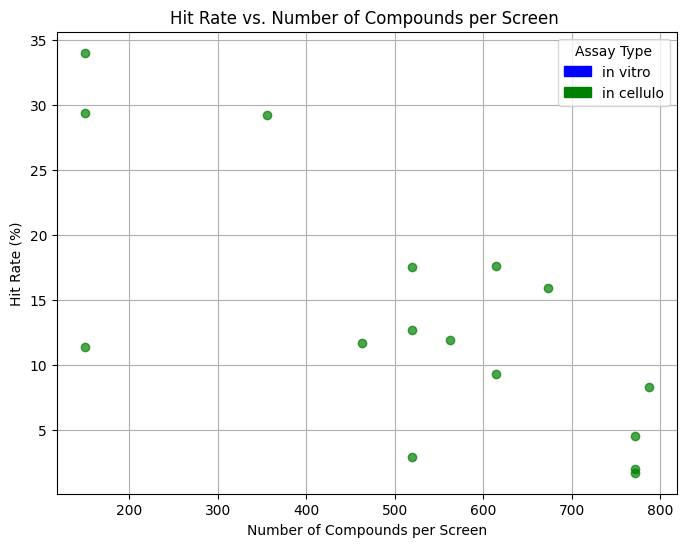

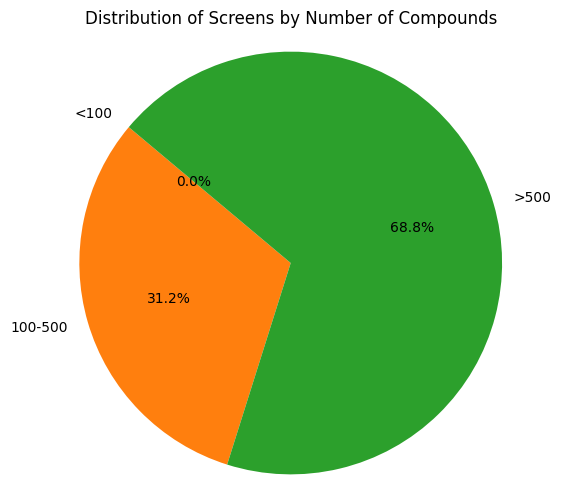

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define the folder path that contains the CSV files for Curie screens
screens_folder = Path("/projects/synsight/repos/phenospace/bioproxy/screens_data_curie")

# List all CSV files in the folder
csv_files = list(screens_folder.glob("*.csv"))

# Create an empty list to store summary information per screen
screens_summary = []

# Process each CSV file
for file in csv_files:
    # Load the CSV file; adjust read_csv parameters if needed
    df = pd.read_csv(file)
    
    # Count the number of active and inactive compounds
    active_count = (df["role_val"] == "hit").sum()
    inactive_count = (df["role_val"] == "none").sum()
    total_count = active_count + inactive_count
    
    # Compute the hit rate if there are any compounds
    hit_rate = active_count / total_count if total_count > 0 else None
    
    # Save the results with the screen name (derived from the file name)
    screens_summary.append({
         "screen": "in-cellulo",  # Using file stem as the screen name
         "active_count": active_count,
         "inactive_count": inactive_count,
         "total_count": total_count,
         "hit_rate": hit_rate
    })

# Convert the list into a DataFrame for plotting and further analysis
df_summary = pd.DataFrame(screens_summary)
print(df_summary)

# ---------------------------
# Scatter Plot: Hit Rate vs. Number of Compounds per Screen
# ---------------------------
plt.figure(figsize=(8,6))
plt.scatter(df_summary["total_count"], df_summary["hit_rate"]*100, color='green', alpha=0.7)
plt.xlabel("Number of Compounds per Screen")
plt.ylabel("Hit Rate (%)")
plt.legend(handles=legend_handles, title="Assay Type")

plt.title("Hit Rate vs. Number of Compounds per Screen ")
plt.grid(True)



# ---------------------------
# Pie Chart: Distribution of Screens by Total Compound Count
# ---------------------------
# Here we define bins for grouping the screens.
bins = [0, 100, 500, df_summary["total_count"].max() + 1]
labels = ["<100", "100-500", ">500"]
df_summary["compound_group"] = pd.cut(df_summary["total_count"], bins=bins, labels=labels, right=False)

# Count the number of screens in each group
group_counts = df_summary["compound_group"].value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Screens by Number of Compounds")
plt.axis('equal')
plt.show()
